In [1]:
import numpy as np
from scipy.stats import norm
from scipy.linalg import cholesky
from scipy import linalg
import matplotlib.pyplot as plt
from itertools import combinations, chain

In [2]:
def read_prostate_data():
    x = np.loadtxt("E:/data_mining/模型评价/prostate/x.txt", delimiter=",")
    y = np.loadtxt("E:/data_mining/模型评价/prostate/y.txt", delimiter=",")
    index = np.loadtxt("E:/data_mining/模型评价/prostate/index.txt", delimiter=",", dtype=bool)
    names = np.loadtxt("E:/data_mining/模型评价/prostate/names.txt", delimiter=",", dtype=str)
    return x, y, index, names

In [3]:
"""调用"""
x, y, index, names = read_prostate_data()

In [4]:
def sigma_mat(p, rho):
    sigma = np.ones((p, p))
    for i in range(p - 1):
        sigma[range(p - i - 1), range(i + 1, p)] = rho ** (i + 1)
        sigma[range(i + 1, p), range(p - i - 1)] = rho ** (i + 1)
    return sigma

In [5]:
def generate_data(p, n, rho, mu, beta):
    z = norm.rvs(size=(n, p))
    V = sigma_mat(p, rho) #调用函数sigma_mat
    L = cholesky(V)
    
    xtrain = np.dot(z, L)
    ytrain = mu + np.dot(xtrain, beta) + norm.rvs(size=n)  # 训练集
    
    z = norm.rvs(size=(n, p))
    xtest = np.dot(z, L)
    ytest = mu + np.dot(xtest, beta) + norm.rvs(size=n)  # 测试集
    
    inds_ = [combinations(range(p), i) for i in range(1, p + 1)]
    inds_1 = [[list(ind_) for ind_ in ind] for ind in inds_]
    p_1 = np.array([len(ind) for ind in inds_1])
    inds = [list(ind_) for ind in inds_1 for ind_ in ind]
    
    return xtrain, ytrain, xtest, ytest, inds, p_1

In [6]:
"""调用"""
p = 8
n = 10000
rho = 0.5
mu = 1
beta = np.array([1, 0]*int(p/2))
data = generate_data(p, n, rho, mu, beta)
xtrain, ytrain, xtest, ytest, inds, p_1 = generate_data(p, n, rho, mu, beta)

In [7]:
def predict_err(x, y, b):
    b0, b1 = b
    err = y - b0 - np.dot(x, b1)
    return np.inner(err, err)

In [8]:
def ols(x, y):
    """
    用普通最小二乘法（Ordinary Least Squares）来估计线性回归模型的参数
    """
    n, _ = np.shape(x)
    x_mean = x.mean(axis=0)
    y_mean = y.mean()
    xt = x.T
    xx = np.dot(xt, x)
    xy = np.dot(xt, y)
    xx_center = xx - n * np.outer(x_mean, x_mean)
    xy_center = xy - n * y_mean * x_mean
    L = linalg.cholesky(xx_center)
    beta_1, _ = linalg.lapack.dpotrs(L, xy_center)
    beta_0 = y_mean - np.inner(beta_1, x_mean)
    return beta_0, beta_1

In [9]:
def plot_predict_errors(xtrain, ytrain, xtest, ytest, inds, p_1, n):
    """接受函数generate_data的所有返回值以及n作为参数"""
    re_b = [ols(xtrain[:, ind], ytrain) for ind in inds]# 调用函数ols
    err_test = np.array([predict_err(xtest[:, ind], ytest, b_) for ind, b_ in zip(inds, re_b)])
    rss = np.array([predict_err(xtrain[:, ind], ytrain, b_) for ind, b_ in zip(inds, re_b)])
    rss_p = np.split(rss, np.cumsum(p_1)[:-1])
    err_test_p = np.split(err_test, np.cumsum(p_1)[:-1])
   
    fig = plt.figure(num=1, figsize=(12, 8))
    for i in range(len(rss_p)):
        ax = fig.add_subplot(2, 4, i+1)
        ax.scatter(rss_p[i]/n, err_test_p[i]/n)
      
    plt.show()

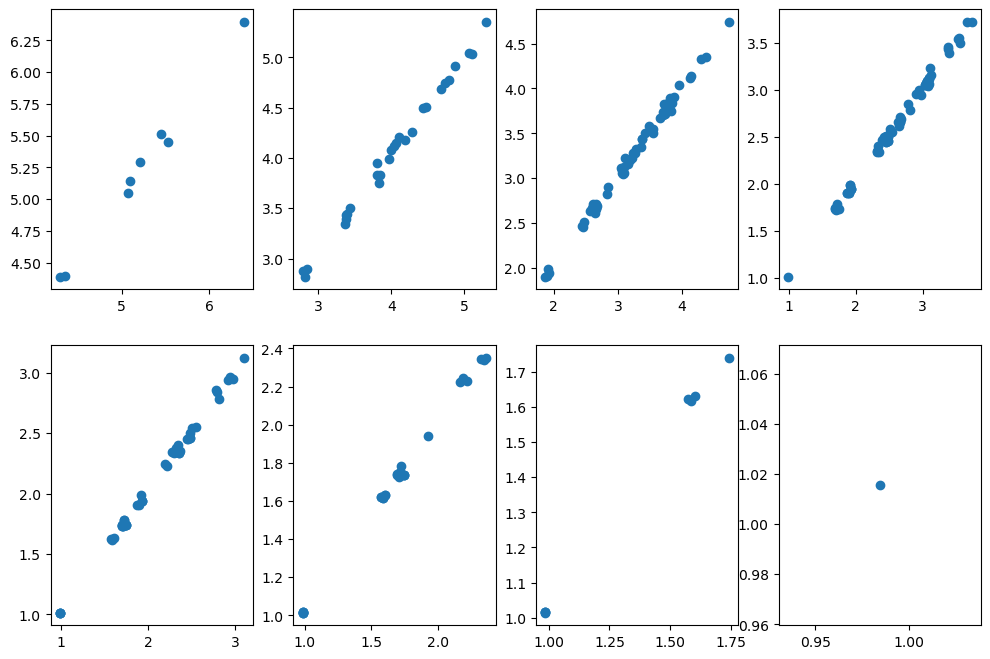

In [10]:
"""调用"""
plot_predict_errors(xtrain, ytrain, xtest, ytest, inds, p_1, n)

In [11]:
def _solve_pos(xtx, xty):
    mat = linalg.cholesky(xtx)
    return linalg.lapack.dpotrs(mat, xty)[0]

In [12]:
def calculate_re_b(xtrain, ytrain, inds):
    """接受函数generate_data的返回值xtrain,ytrain,inds作为参数"""
    n, p = xtrain.shape

    def solve_linear_equations(xtx_center, xty_center, ind):
        """返回一个函数_solve_pos"""
        return _solve_pos(xtx_center[np.ix_(ind, ind)], xty_center[ind])
      
    def calculate_b0_and_b1(ytrain_mean, xtrain_mean, re_b_1, inds):
        re_b_0 = [ytrain_mean - np.dot(xtrain_mean[ind], b_1_) for ind, b_1_ in zip(inds, re_b_1)]
        return re_b_0, re_b_1

    xtrain_mean = xtrain.mean(axis=0)
    xtrain_scale = xtrain - xtrain_mean
    ytrain_mean = ytrain.mean()
    ytrain_scale = ytrain - ytrain_mean

    xtx = np.dot(xtrain_scale.T, xtrain_scale)
    xty = np.dot(xtrain_scale.T, ytrain_scale)
    
    re_b_1 = [solve_linear_equations(xtx, xty, ind) for ind in inds]
              #### 进一步返回linalg.lapack.dpotrs(mat, xty)[0]
    re_b_0, re_b_1 = calculate_b0_and_b1(ytrain_mean, xtrain_mean, re_b_1, inds)
    re_b = [(b_0_, b_1_) for b_0_, b_1_ in zip(re_b_0, re_b_1)]
    
    return re_b, xtrain_mean, xtx, xty

In [13]:
def predict_err(X, y, b):
    predictions = np.dot(X, b)
    errors = y - predictions
    return np.mean(errors ** 2) # 计算均方误差

In [14]:
def calculate_errors_and_rss(xtest, ytest, xtrain, ytrain, inds, re_b):
    """接受函数generate_data的5个返回值和函数calculate_re_b的返回值作为参数"""
    err_test = np.array([predict_err(xtest[:, ind], ytest, b_) for ind, b_ in zip(inds, re_b)])
    rss = np.array([predict_err(xtrain[:, ind], ytrain, b_) for ind, b_ in zip(inds, re_b)])
    d = np.array([len(ind) for ind in inds])
    best_b = re_b[np.argmin(err_test)]
    return err_test, rss, d, best_b

In [15]:
def split_indices(n, k, seed=None):
    """将0到n-1的整数随机排列后分割成k个子集"""
    if seed is not None:
        np.random.seed(seed)

    indices = np.random.permutation(np.arange(n))
    return np.array_split(indices, k)

In [16]:
def regression_coefficients(xtrain, ytrain, xtrain_mean, x, y, xtx, xty, K):  
    """接受函数generate_data的返回值xtrain,ytrain、
    函数calculate_re_b的返回值xtrain_mean,xtx,xty等作为参数"""
    
    n = xtrain.shape[0]
    indexs = split_indices(n, K, seed=100)#调用函数split_indices
    index = indexs[0]
    index_ = np.setdiff1d(np.arange(n), index, assume_unique=False)
    
    n_i = len(index)
    n_i_ = n - n_i
    x_i = x[index, :]  
    y_i = y[index]  

    x_mean_i = np.mean(x_i, axis=0)  
    y_mean_i = np.mean(y_i)  

    xt_i = x_i.T
    xtx_i = np.dot(xt_i, x_i) - n_i * np.outer(x_mean_i, x_mean_i)  
    xty_i = np.dot(xt_i, y_i) - n_i * y_mean_i * x_mean_i  


    x_mean_i_ = (n * xtrain_mean - n_i * x_mean_i) / n_i_
    y_mean_i_ = (n * np.mean(ytrain) - n_i * y_mean_i) / n_i_

    x_mean_i__ = x_mean_i - xtrain_mean
    y_mean_i__ = y_mean_i - np.mean(ytrain)

    xtx_i_ = xtx - xtx_i - (n_i * n / n_i_) * np.outer(x_mean_i__, x_mean_i__)
    xty_i_ = xty - xty_i - (n_i * n / n_i_) * y_mean_i__ * x_mean_i__

    b_1_i = np.linalg.solve(xtx_i_, xty_i_)
    b_0_i = y_mean_i_ - np.inner(x_mean_i_, b_1_i)
    b_i = (b_0_i, b_1_i)
    
    re_b_1_i = [_solve_pos(xtx_i[np.ix_(ind, ind)], xty_i[ind]) for ind in inds]
    re_b_0_i = [y_mean_i_ - np.inner(x_mean_i[ind], b_1_i) for ind, b_1_i in zip(inds, re_b_1_i)]
    cv_err_i = [predict_err(xtrain[:, ind], ytrain, (b_0_i, b_1_i))
                for ind, b_0_i, b_1_i in zip(inds, re_b_0_i, re_b_1_i)]
      
    for i, (b_0, b_1, err) in enumerate(zip(re_b_0_i, re_b_1_i, cv_err_i)):
        print(f"Coefficients for index {i}: b_0 = {b_0}, b_1 = {b_1}")
        print(f"Prediction error for index {i}: {err}")
    
    cv_err_mat = np.array([cv_err_i_fun(index) for index in indexs])
    print(cv_err_mat.shape)
    cv_err = cv_err_mat.sum(axis=0) / n
    print(names[inds[np.argmin(cv_err)]])
    print(cv_err)
    
    return

In [17]:
x, y, index, names = read_prostate_data()
p = 8
n = 10000
rho = 0.5
mu = 1
beta = np.array([1, 0]*int(p/2))

In [18]:
# """调用"""
# data = generate_data(p, n, rho, mu, beta)
# xtrain, ytrain, xtest, ytest, inds, p_1 = generate_data(p, n, rho, mu, beta)
# plot_predict_errors(xtrain, ytrain, xtest, ytest, inds, p_1, n)
# re_b, xtrain_mean, xtx, xty = calculate_re_b(xtrain, ytrain, inds)

# linalg.lapack.dpotrs(mat, xty)[0] = _solve_pos(xtx, xty)
"""这行报错..."""

# err_test, rss, d, best_b = calculate_errors_and_rss(xtest, ytest, xtrain, ytrain, inds, re_b)
# indices_split = split_indices(n, k, seed=None)
# regression_coefficients(xtrain, ytrain, xtrain_mean, x, y, xtx, xty, K)

'这行报错...'

In [19]:
class DataProcessor:
    def __init__(self, p, n, rho, mu, beta, k=5, seed=None):
        self.p = p
        self.n = n
        self.rho = rho
        self.mu = mu
        self.beta = beta
        self.k = k
        self.seed = seed

    def generate_data(self):
        return generate_data(self.p, self.n, self.rho, self.mu, self.beta)

    def plot_predict_errors(self):
        xtrain, ytrain, xtest, ytest, inds, p_1 = generate_data(self.p, self.n, self.rho, self.mu, self.beta)
        plot_predict_errors(xtrain, ytrain, xtest, ytest, inds, p_1, self.n)

    def calculate_re_b(self):
        xtrain, ytrain, _, _ = generate_data(self.p, self.n, self.rho, self.mu, self.beta)
        re_b, xtrain_mean, xtx, xty = calculate_re_b(xtrain, ytrain, inds)
        return re_b, xtrain_mean, xtx, xty

    def calculate_errors_and_rss(self):
        xtrain, ytrain, xtrain_mean, x, y, xtx, xty = self.calculate_re_b()
        best_b = linalg.lapack.dpotrs(mat, xty)[0] = _solve_pos(xtx, xty)
        err_test, rss, d, _ = calculate_errors_and_rss(xtest, ytest, xtrain, ytrain, inds, re_b)
        return err_test, rss, d, best_b

    def split_indices(self):
        return split_indices(self.n, self.k, self.seed)

    def regression_coefficients(self):
        xtrain, ytrain, xtrain_mean, x, y, xtx, xty = self.calculate_re_b()
        indices_split = self.split_indices()
        regression_coefficients(xtrain, ytrain, xtrain_mean, x, y, xtx, xty, indices_split)

In [20]:
# 实例化DataProcessor类
data_processor = DataProcessor(p=10, n=100, rho=0.5, mu=0, beta=1, k=5, seed=42)
data = data_processor.generate_data()
data_processor.plot_predict_errors()
re_b, xtrain_mean, xtx, xty = data_processor.calculate_re_b()
err_test, rss, d, best_b = data_processor.calculate_errors_and_rss()
data_processor.regression_coefficients()

# ...T_T......X_X...

ValueError: operands could not be broadcast together with shapes (100,10) (100,) 